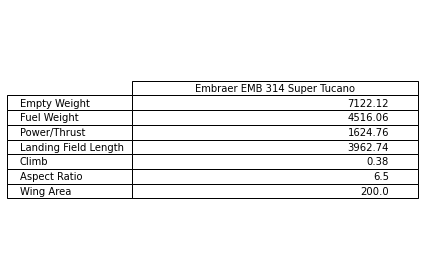

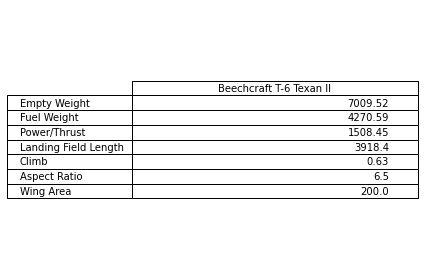

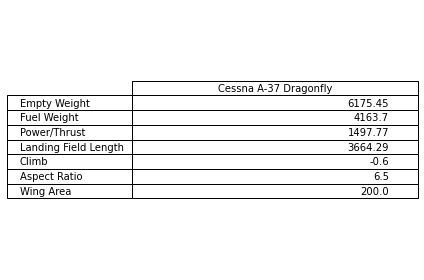

In [5]:

import matplotlib.pyplot as plt
import scipy.optimize as opt
import numpy as np
import pandas as pd

global s_land, engine, TP_req

def get_altP(h):
    T0 = 59 # F
    P0 = 2118.145 # lbs/ft^2
    rho0 = 0.0023769 # slugs/ft^3
    if h < 36152: # Within this altitude range
        T = 59 - 0.00356*h
        P = 2116 * ((T+459.7)/518.6)**5.256
    elif 36152 <= h and h <= 82345: # Within this altitude range
        T = -70
        P = 473.1 * np.exp(1.73-0.000048*h)
    elif h > 82345: # Within this altitude range
        T = -205.05 + 0.00164*h
        P = 51.97 * ((T+459.7)/389.98)**-11.388
    rho = P / (1718*(T+459.7))
    c = (1.4 * 1716 * (T+459.7))**0.5 * 0.5925 # Gives speed of sound in knots
    return (T, P, rho, (T+459.7)/(T0+459.7), P/P0, rho/rho0, c)

def eq_hpR(h):
    TO_sig = get_altP(h)[5] # Returns the equivalent power required at SL
    R = 1.132 * TO_sig - 0.132
    if R < 0:
        R = 0
    return R

def eq_T_R(h):
    TO_sig = get_altP(h)[5] # Returns the equivalent thrust required at SL
    R = 1.132 * TO_sig - 0.132
    if R < 0:
        R = 0
    return R


# Iterates through each segment of the mission and finds the fuel fraction of
# that segment, will also return the max power required during the mission
def mission_fuel(mission, wet_ref, A_wing, AR, SFC, Wo, l_ref):
    global s_land, engine
    WeWo = 1 # Starts with a fraction of one
    PT_max = 0
    for seg in mission: # Iterates through each segment
        if seg[0] == 'TO':
            WeWo *= 0.97
        elif seg[0] == 'climb':
            WeWo *= 0.98
        elif seg[0] == 'decent':
            WeWo *= 0.995
        elif seg[0] == 'land':
            WeWo *= 0.992
            W_curr = WeWo * Wo
            Cl_max = 1.6
            s_a = 600
            # Gets landing length to ensure requiremnts are met (at altitude)
            s_land = 80*(W_curr/A_wing)/(Cl_max*get_altP(seg[2])[5]) + s_a
        elif seg[0] == 'cruise':
            W_curr = WeWo * Wo
            # Finds cruise mach number and dynamic pressure
            M = seg[2] / get_altP(seg[3])[6]
            rho = get_altP(seg[3])[2]
            Re = (rho*32.174)*(1.688*seg[2]*60)*l_ref/0.040880
            q = 0.5 * rho * (1.688*seg[2])**2
            
            # Gets span effificency, induced drag coef, and fiction coef
            e = 1.78*(1-0.045*(AR**0.68)) - 0.64     
            K = 1/(np.pi*AR*e)
            Cf = 0.455/(np.log10(Re)**2.58 * (1 + 0.144*M**2)**0.65)
            
            # Calculates the lift required and uses that to get drag produced
            Cl = W_curr / (q * A_wing)
            Cd = Cf * wet_ref + K * Cl**2
            ClCd = Cl/Cd
            if engine == 'prop':
                # Power Required
                n_p = 0.82
                PT = seg[2]/(550*n_p) * (1/ClCd) * W_curr / eq_hpR(seg[3])
                PT_max = max(PT, PT_max)
                # Perfomance Calc
                WeWo *= np.exp(-(seg[1]*SFC)/(550*n_p*ClCd))
            else:
                PT = Cd*q*A_wing / eq_hpR(seg[3]) # Lift is equal to drag
                PT_max = max(PT, PT_max)
                # Perfomance Calc
                WeWo *= np.exp(-(seg[1]*SFC)/(seg[2]*ClCd))
        elif seg[0] == 'loiter':
            W_curr = WeWo * Wo
            # Finds cruise mach number and dynamic pressure
            M = seg[2] / get_altP(seg[3])[6]
            rho = get_altP(seg[3])[2]
            Re = (rho*32.174)*(1.688*seg[2]*60)*l_ref/0.040880
            q = 0.5 * rho * (1.688*seg[2])**2
            
            # Gets span effificency, induced drag coef, and fiction coef
            e = 1.78*(1-0.045*(AR**0.68)) - 0.64
            K = 1/(np.pi*AR*e)
            Cf = 0.455/(np.log10(Re)**2.58 * (1 + 0.144*M**2)**0.65)
            
            # Calculates the lift required and uses that to get drag produced
            Cl = W_curr / (q * A_wing)
            Cd = Cf * wet_ref + K * Cl**2
            ClCd = Cl/Cd
            if engine == 'prop':
                # Perfomance Calc
                n_p = 0.82
                WeWo *= np.exp(-(seg[1]*seg[2]*SFC)/(550*n_p*ClCd))
                # Power Required
                PT = seg[2]/(550*n_p) * (1/ClCd) * W_curr / eq_hpR(seg[3])
                PT_max = max(PT, PT_max)
            else:
                PT = Cd*q*A_wing / eq_hpR(seg[3]) # Lift is equal to drag
                PT_max = max(PT, PT_max)
                # Perf Calc
                WeWo *= np.exp(-(seg[1]*SFC)/ClCd)
    return WeWo, PT_max

# This program is iterated similiar to the spreadsheet
def D_weight(weights, params, w_add, mission, field_L, seed):
    global engine, TP_req
    # Setup for weights and dimensions that will be changed
    Wfuel, DW = weights
    AR, A_wing = params
    # Checks to make sure wing is valad
    if AR < 0 or A_wing < 0:
        return None, None
    # Adds delta weight to empty and uses that to find max (or gross) weight
    We = seed['emptyW'] + DW
    Wmax = We + Wfuel + w_add
    
    # Gets tail areas using basic assumptions
    A_Vtail = 0.125*A_wing
    A_Htail = 0.25*A_wing
    
    # Finds wetted area for all componenets and sums them together
    A_S_ratio = 2.05
    s_wing = A_S_ratio * A_wing
    s_Vtail = A_S_ratio * A_Vtail
    s_Htail = A_S_ratio * A_Htail
    s_wet = s_wing + s_Vtail + s_Htail + seed['Swet_fuse']
    wet_ref = s_wet / A_wing
    
    # Mission analysis
    if engine == 'prop':
        SFC = 0.54 # Power specific fuel consumption
    else:
        SFC = 0.96 # Thrust specific fuel consumption
    WeWo, TP_CR = mission_fuel(mission,wet_ref,A_wing,AR,SFC,Wmax,seed['fuse_len'])
    
    # Take off for calculating max power or thrust
    TO_R = eq_hpR(mission[0][2])
    if engine == 'prop':
        TOP = 1e-6*field_L**2 + 0.1021*field_L + 9.9376
    else:
        TOP = -1e-7*field_L**2 + 0.0524*field_L + 1.04
    Cl_TO = 1.45
    TP_TO = (Wmax**2) / (A_wing*TOP*TO_R*Cl_TO)
    # Compares max power requred so engine can perform all parts of mission
    TP_req = max(TP_CR,TP_TO)
    
    #print(We, Wfuel, w_add)
    # Delta weights calcultaed using linear realtionship between parameters
    DW_wing = 9 * (A_wing - seed['A_wing'])
    DW_Vtail = 5.3 * (A_Vtail - seed['A_Vtail'])
    DW_Htail = 5.3 * (A_Htail - seed['A_Htail'])
    DW_eng = 0
    if seed['engine'] == 'prop':
        DW_eng -= 296 + 0.228 * seed['TOpower']
        if engine == 'prop':
            DW_eng += 296 + 0.228 * TP_req
        else:
            DW_eng += 0.23 * TP_req - 418
    else:
        DW_eng -= 0.23 * seed['TOpower'] - 418
        if engine == 'prop':
            DW_eng += 296 + 0.228 * TP_req
        else:
            DW_eng += 0.23 * TP_req - 418
    # Return values for iteration
    DWcalc = DW_wing + DW_Vtail + DW_Htail + DW_eng
    Wfuelcalc = (1-WeWo) * Wmax
    return Wfuel - Wfuelcalc, DW - DWcalc

# Iterates though cruise velocities for max alitude
def max_climb(v, max_alt, PT, Wo, wet_ref, A_wing, AR, l_ref):
    global engine
    # Weight after take off (heavier means harder to climb)
    W_curr = 0.97 * Wo
    n_p = 0.82
    rho = get_altP(max_alt)[2]
    if engine == 'prop':
        TW = ((550*n_p)/v) * (eq_hpR(max_alt)*PT) / W_curr
    else:
        TW = eq_hpR(max_alt)*PT / W_curr
    q = 0.5 * rho * (1.688*v)**2
    e = 1.78*(1-0.045*(AR**0.68)) - 0.64
    WS = W_curr / A_wing
    
    # Similiar to mission calc for coef of fric
    M = v / get_altP(max_alt)[6]
    Re = (rho*32.174)*(1.688*v*60)*l_ref/0.040880
    K = 1/(np.pi*AR*e)
    Cf = 0.455/(np.log10(Re)**2.58 * (1 + 0.144*M**2)**0.65)
    
    # Unlike before get drag to weight ratio
    Cd0 = Cf * wet_ref
    DW = (q*Cd0)/WS + WS*K/q
    # When thrust to weight is equal to drag to weight ceiling is achived
    return -(TW - DW)

def find_G(weights, params, w_add, mission, field_L, seed):
    global engine
    # Setup for weights and dimensions that will be changed
    Wfuel, DW = weights
    AR, A_wing = params
    # Checks to make sure wing is valad
    if AR < 0 or A_wing < 0:
        return None, None
    # Adds delta weight to empty and uses that to find max (or gross) weight
    We = seed['emptyW'] + DW
    Wmax = We + Wfuel + w_add
    
    # Gets tail areas using basic assumptions
    A_Vtail = 0.125*A_wing
    A_Htail = 0.25*A_wing
    
    # Finds wetted area for all componenets and sums them together
    A_S_ratio = 2.05
    s_wing = A_S_ratio * A_wing
    s_Vtail = A_S_ratio * A_Vtail
    s_Htail = A_S_ratio * A_Htail
    s_wet = s_wing + s_Vtail + s_Htail + seed['Swet_fuse']
    wet_ref = s_wet / A_wing
    
    # Mission analysis
    if engine == 'prop':
        SFC = 0.54 # Power specific fuel consumption
    else:
        SFC = 0.96 # Thrust specific fuel consumption
    WeWo, TP_CR = mission_fuel(mission,wet_ref,A_wing,AR,SFC,Wmax,seed['fuse_len'])
    
    # Take off for calculating max power or thrust
    TO_R = eq_hpR(mission[0][2])
    if engine == 'prop':
        TOP = 1e-6*field_L**2 + 0.1021*field_L + 9.9376
    else:
        TOP = -1e-7*field_L**2 + 0.0524*field_L + 1.04
    Cl_TO = 1.45
    TP_TO = (Wmax**2) / (A_wing*TOP*TO_R*Cl_TO)
    # Compares max power requred so engine can perform all parts of mission
    TP_req = max(TP_CR,TP_TO)
    # Get Max Climb
    cl_inpt = (30000, TP_req, Wmax, wet_ref, A_wing, AR, seed['fuse_len'])
    sol = opt.minimize(max_climb, 300, args=cl_inpt)
    G = -sol['fun']
    v = float(sol['x'])
    return 1.69 * G * v

# Basic constraints for diffrent mission params
v_cruise = 350
w_payload = 3000
w_crew = 225*2
engine = 'prop' # Can be 'prop' or 'jet'

missionD = [['TO',None,6000],
            ['climb',v_cruise,10000],
            ['cruise',100,v_cruise,10000],
            ['decent',None,3000],
            ['loiter',4,v_cruise,3000],
            ['climb',v_cruise,10000],
            ['cruise',100,v_cruise,10000],
            ['decent',None,0],
            ['land',None,6000],
            ['climb',v_cruise,3000],
            ['loiter',0.75,v_cruise,3000]]

missionF = [['TO',None,6000],
            ['climb',v_cruise,18000],
            ['cruise',900,v_cruise,18000],
            ['decent',None,0],
            ['land',None,6000],
            ['climb',v_cruise,3000],
            ['loiter',0.75,v_cruise,3000]]

missions = [missionD, missionF]

tucano = {'name':'Embraer EMB 314 Super Tucano',
          'engine':'prop',
          'emptyW':7055,
          'AR':6.67,
          'TOpower':1604,
          'A_wing':206,
          'A_Htail':53.448,
          'A_Vtail':25.155,
          'Swet_fuse':396.976,
          'fuse_len':37.333}

texan = {'name':'Beechcraft T-6 Texan II',
         'engine':'prop',
         'emptyW':6500, # Baisc Empty Weight
          'AR':6.29,
          'TOpower':1100,
          'A_wing':177.5,
          'A_Htail':38.701,
          'A_Vtail':22.03,
          'Swet_fuse':304.833,
          'fuse_len':33.25}

dragonfly = {'name':'Cessna A-37 Dragonfly',
         'engine':'jet',
         'emptyW':6211,
          'AR':6.2,
          'TOpower':5700,
          'A_wing':189.9,
          'A_Htail':45.09,
          'A_Vtail':20.856,
          'Swet_fuse':304.833,
          'fuse_len':30.534}

planes = [tucano, texan, dragonfly]

# Calculates total added weight for each mission
w_addD = w_payload + w_crew
w_addF = 0.6*w_payload + w_crew

# Initial guess for fueal weight and delta weight for bpth missions
weights = (3000, 0)

# Range for aspect ratio and wing area
AR = 6.5
A_wing = 200

#print(D_weight(params, weights, w_add, missionD, 4000, tucano))

# Goes through each seed aircraft
for plane in planes:
    
    # Required field length
    field_L = 4000
    # Makes each imput a tuple for inserting into optimization function
    inptD = (w_addD, missionD, field_L, plane)
    inptF = (w_addF, missionF, field_L, plane)
    # Runs though each aspect ratio and wing area
    # Gets parameters used for this instance
    params = AR, A_wing
    
    # Finds solution for design mission
    solD = opt.root(D_weight, weights, args=(params,)+inptD)['x']
    s_landD = s_land
    
    # Finds solution for design mission
    solF = opt.root(D_weight, weights, args=(params,)+inptF)['x']
    s_landF = s_land
    
    # Chooses heavier solution
    sol = solD if solD[0] > solF[0] else solF
    # Chooses same landing solution as weight solution
    land = s_landD if s_landD > s_landF else s_landF
    
    # Gets climb rate for selected mission
    if sol[0] == solD[0]:
        climb = find_G(solD,params,w_addD,missionD,field_L,plane)
    else:
        climb = find_G(solF,params,w_addF,missionF,field_L,plane)
    w_fuel = sol[0]
    we = sol[1] + inptD[3]['emptyW']
    w_TO = sol[1] + inptD[3]['emptyW'] + sol[0] + inptD[0]
    
    # Plot table with values
    fig, ax = plt.subplots()
    
    # hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')
    data_tab = [we, w_fuel, TP_req, land, climb, AR, A_wing]
    
    df = pd.DataFrame([round(elm, 2) for elm in data_tab], 
                      columns=[plane['name']],
                      index=["Empty Weight", "Fuel Weight", "Power/Thrust",
                             "Landing Field Length", "Climb",
                             "Aspect Ratio", "Wing Area"])
    
    ax.table(cellText=df.values, colLabels=df.columns,
             rowLabels=df.index, loc='center')
    
    fig.tight_layout()

plt.show()
